In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import keras 

In [3]:
!unzip '/content/drive/MyDrive/Colab Notebooks/en-fr.csv.zip'

Archive:  /content/drive/MyDrive/Colab Notebooks/en-fr.csv.zip
  inflating: en-fr.csv               


# **Reading the file:**
I tried using different methods of file reading as pandas and modin but all of them took so much time that my runtime crashed for every method. I did it in different notebook because I did not want my work here to crash.
Only Dask method worked for me so I used it in this notebook instead of pandas.

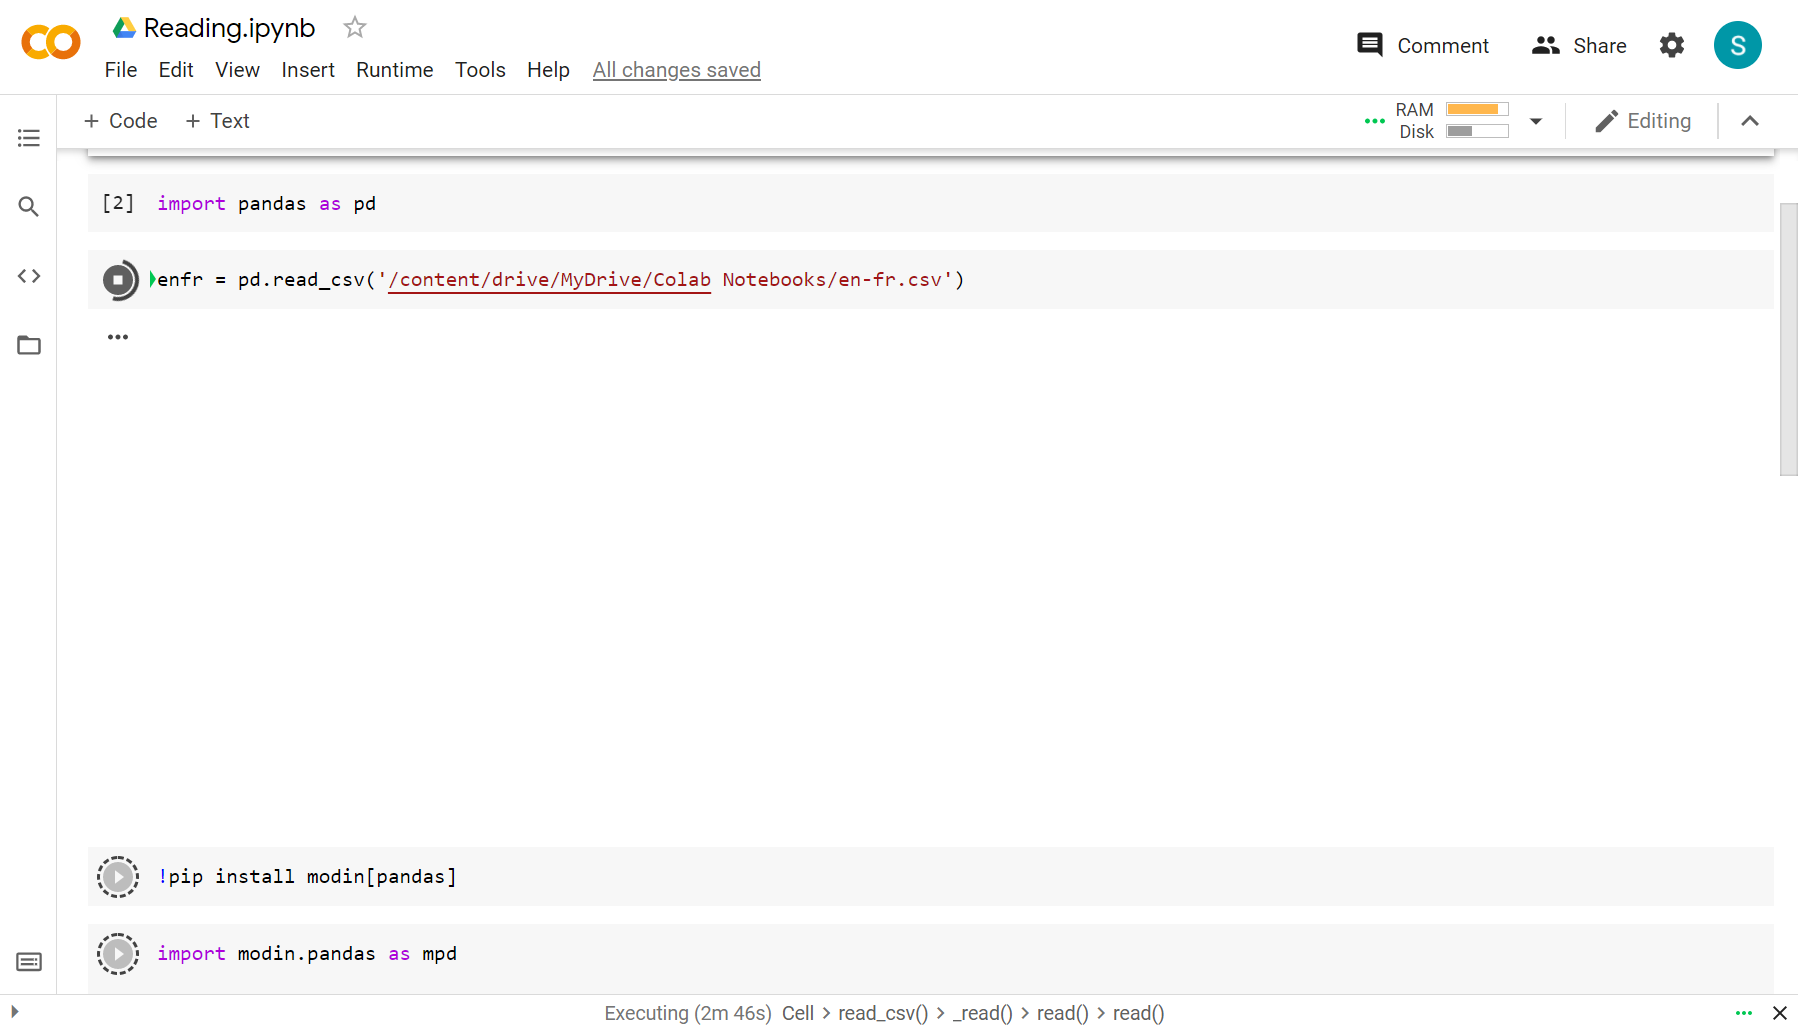

# **Data Ingestion:**

In [4]:
%%writefile testutility.py
import logging
import os
import subprocess
import yaml
import pandas as pd
import datetime 
import gc
import re



def read_config_file(filepath):
    with open(filepath, 'r') as stream:
        try:
            return yaml.safe_load(stream)
        except yaml.YAMLError as exc:
            logging.error(exc)



def replacer(string, char):
    pattern = char + '{2,}'
    string = re.sub(pattern, char, string) 
    return string

def col_header_val(df,table_config):
    '''
    replace whitespaces in the column
    and standardized column names
    '''
    df.columns = df.columns.str.lower()
    df.columns = df.columns.str.replace('[^\w]','_',regex=True)
    df.columns = list(map(lambda x: x.strip('_'), list(df.columns)))
    df.columns = list(map(lambda x: replacer(x,'_'), list(df.columns)))
    expected_col = list(map(lambda x: x.lower(),  table_config['columns']))
    expected_col.sort()
    df.columns =list(map(lambda x: x.lower(), list(df.columns)))
    df = df[sorted(df.columns)]
    if len(df.columns) == len(expected_col) and list(expected_col)  == list(df.columns):
        print("column name and column length validation passed")
        return 1
    else:
        print("column name and column length validation failed")
        mismatched_columns_file = list(set(df.columns).difference(expected_col))
        print("Following File columns are not in the YAML file",mismatched_columns_file)
        missing_YAML_file = list(set(expected_col).difference(df.columns))
        print("Following YAML columns are not in the file uploaded",missing_YAML_file)
        logging.info(f'df columns: {df.columns}')
        logging.info(f'expected columns: {expected_col}')
        return 0

Writing testutility.py


In [5]:
%%writefile file.yaml
file_type: csv
dataset_name: fromEnglishToFrench
file_name: en-fr
table_name: edsurv
inbound_delimiter: ","
outbound_delimiter: "|"
skip_leading_rows: 1
columns: 
    - en
    - latin
    - fr


Writing file.yaml


In [6]:
import testutility as util
config_data = util.read_config_file("/content/file.yaml")
config_data

{'columns': ['en', 'latin', 'fr'],
 'dataset_name': 'fromEnglishToFrench',
 'file_name': 'en-fr',
 'file_type': 'csv',
 'inbound_delimiter': ',',
 'outbound_delimiter': '|',
 'skip_leading_rows': 1,
 'table_name': 'edsurv'}

In [7]:
config_data['inbound_delimiter']

','

In [8]:
!pip install dask[dataframe]

     |████████████████████████████████| 118 kB 35.4 MB/s 


In [9]:

import dask.dataframe as dd

df = dd.read_csv('/content/en-fr.csv')
df.head()

,en,fr
0,Changing Lives | Changing Society | How It Wor...,Il a transformé notre vie | Il a transformé la...
1,Site map,Plan du site
2,Feedback,Rétroaction
3,Credits,Crédits
4,Français,English


In [10]:
util.col_header_val(df,config_data)

column name and column length validation failed
Following File columns are not in the YAML file []
Following YAML columns are not in the file uploaded ['latin']


0

In [11]:
print("columns of files are:" ,df.columns)
print("columns of YAML are:" ,config_data['columns'])

columns of files are: Index(['en', 'fr'], dtype='object')
columns of YAML are: ['en', 'latin', 'fr']


In [12]:

if util.col_header_val(df,config_data)==0:
    print("validation failed")
    
else:
    print("col validation passed")
   

column name and column length validation failed
Following File columns are not in the YAML file []
Following YAML columns are not in the file uploaded ['latin']
validation failed


**Pipe seperated text file in gz format**

In [13]:
import csv
outf = open('file.txt','w')
with open('en-fr.csv','r') as inf:
    reader = csv.reader(inf, delimiter=',')
    header = next(reader)
    for row in reader:
        english = row[0]
        french = row[1]
        line ='{}|{}\n'.format(english, french)
        outf.write(line)
outf.close()

In [14]:
import zipfile
my_zip = zipfile.ZipFile('data.zip','w')
my_zip.write('file.txt')
my_zip.close()

In [15]:
#Counting the rows
#count = len(open('file.txt').readlines())

I believe this is the right formula for counting the lines of a text file since I don't get any error but my runtime crashes whenever I run this code probably due to the fact that this is a very large size file while my PC can't handle such big files.

In [18]:
#CHECKING THE SIZE
import os 
size = os.stat('file.txt').st_size #size in bytes
size

8355144846

In [23]:
#Create a summary

summary = open('summary.txt','w')
size1 = repr(size)
#count1 = repr(count)
summary.write('Number of Columns: ' + '2' +'\n' + 'Number of rows: ' + '#count1' + '\n' + 'The size of the file: ' + size1 )
summary.close()